# Классическая свёрточная нейронная сеть LeNet-5

Сеть LeNet-5 была [представлена](https://www.researchgate.net/publication/2985446_Gradient-Based_Learning_Applied_to_Document_Recognition) в 1998 году и представляла из себя сеть из 2 свёрточных слоёв, 2 слоёв подвыборки и 3 полносвязных слоёв.\
Все свёртки были размером $5\times5$.\
Функция активации: *сигмоида* (ReLU ещё не придумали)\
Слои подвыборки: *усреднения*

![Lenet5](media/lenet5.svg "LeNeT-5")

In [1]:
import os
import struct
import numpy as np
import torch
from torch.nn import Module
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import trange

_ = torch.manual_seed(1)

In [2]:
class Model(Module):
    def __init__(self, activation):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.a1 = nn.Sigmoid() if activation == 'Sigmoid' else nn.ReLU()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.a2 = nn.Sigmoid() if activation == 'Sigmoid' else nn.ReLU()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.a3 = nn.Sigmoid() if activation == 'Sigmoid' else nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.a4 = nn.Sigmoid() if activation == 'Sigmoid' else nn.ReLU()
        self.fc3 = nn.Linear(84, 10)
        self.a5 = nn.GELU()
        

    def forward(self, x):
        y = self.conv1(x)
        y = self.a1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.a2(y)
        y = self.pool2(y)
#         y = y.view(y.shape[0], -1)  # взаимозаменяемо с nn.Flatten()
        y = self.flatten(y)
        y = self.fc1(y)
        y = self.a3(y)
        y = self.fc2(y)
        y = self.a4(y)
        y = self.fc3(y)
        y = self.a5(y)
        return y

![Gelu](media/gelu.png "GELU")

In [3]:
# Чтение данных из MNIST
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [4]:
mnist_root = 'media/MNIST'
files = {
    'train_images': os.path.join(mnist_root, 'train-images.idx3-ubyte'),
    'train_labels': os.path.join(mnist_root, 'train-labels.idx1-ubyte'),
    'test_images':os.path.join(mnist_root, 't10k-images.idx3-ubyte'),
    'test_labels':os.path.join(mnist_root, 't10k-labels.idx1-ubyte')
}
dataset = {}
for name, path in files.items():
    dataset[name] = read_idx(path)
    print(f'{len(dataset[name])} items in {name}')
    

60000 items in train_images
60000 items in train_labels
10000 items in test_images
10000 items in test_labels


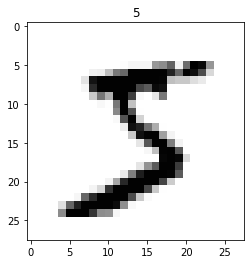

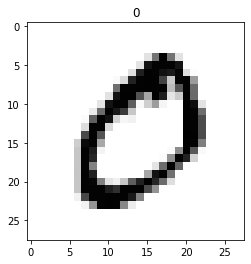

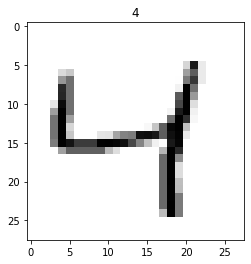

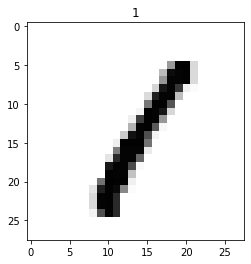

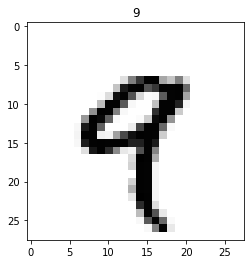

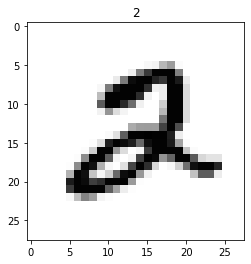

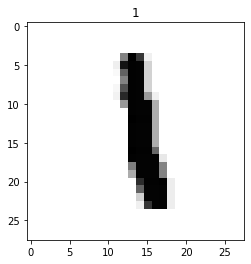

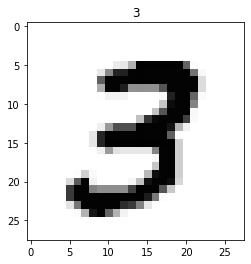

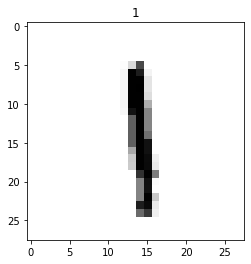

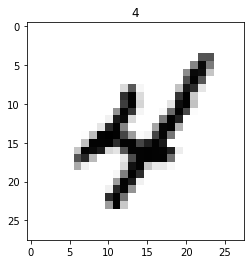

In [5]:
# Показ нескольких первых чисел
for i in range(10):
    plt.title(dataset['train_labels'][i])
    plt.imshow(dataset['train_images'][i], cmap='Greys')
    plt.show()

In [6]:
# подготовка данных
train_mean = np.mean(dataset['train_images'])
train_std = np.std(dataset['train_images'])
print(train_mean, train_std)
dataset['train_images'] = (dataset['train_images'] - train_mean) / train_std

test_mean = np.mean(dataset['test_images'])
test_std = np.std(dataset['test_images'])
print(test_mean, test_std)
dataset['test_images'] = (dataset['test_images'] - train_mean) / train_std

train_label = torch.tensor(dataset['train_labels'], dtype=torch.long)
train_x = torch.tensor(dataset['train_images'], dtype=torch.float32).unsqueeze(1)
test_label = torch.tensor(dataset['test_labels'], dtype=torch.long)
test_x = torch.tensor(dataset['test_images'], dtype=torch.float32).unsqueeze(1)

33.318421449829934 78.56748998339798
33.791224489795916 79.17246322228644


<ipython-input-6-e876fb0cbc7b>:12: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  train_label = torch.tensor(dataset['train_labels'], dtype=torch.long)


In [51]:
def get_losshist_column(activation, optimizer, learning_rate):
    return f'{activation}_{optimizer}_lr{learning_rate}'

def log_loss(epoch, activation, optimizer, learning_rate, loss_history, loss):
    column = get_losshist_column(activation, optimizer, learning_rate)
    loss_history.loc[epoch, column] = loss
    

def get_optimizer(optim_name):
    optims = {
        'adam': Adam,
        'sgd': SGD
    }
    return optims[optim_name.lower()]

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
        
def train_model(epochs, activation, optimizer_name, learning_rate, loss_history, log_dir, model_file=None):
#     print(f'Training model: {activation} {optimizer_name} lr={learning_rate} model file = {model_file}')
    
    if model_file:
        model = torch.load(model_file)
    else:
        model = Model(activation)
        model.apply(init_weights)
    
    optimizer = get_optimizer(optimizer_name)(model.parameters(), lr=learning_rate)
    
    cross_error = CrossEntropyLoss()
    t = trange(epochs)
    
    for e in t:
        t.set_description(f'Epoch {e+1}, {get_losshist_column(activation, optimizer_name, learning_rate)}')
        model.train()
        optimizer.zero_grad()
        predict_y = model(train_x) # для обучения используем весь пакет
        loss = cross_error(predict_y, train_label)
        loss_np = loss.detach().numpy()
        log_loss(e, activation, optimizer_name, learning_rate, loss_history, loss_np)
               
        loss.backward()
        optimizer.step()
        
        correct = 0
        _sum = 0
        model.eval()
        predict_y = model(test_x)
        predict_ys = torch.argmax(predict_y, axis=-1)
        matches = predict_ys == test_label
        correct += torch.sum(matches, axis=-1)
        _sum += matches.shape[0]
        accuracy = correct.numpy() / _sum
        t.set_postfix(loss=loss_np, accuracy=accuracy)
    torch.save(model,
               os.path.join(log_dir, f'lenet{activation}_{optimizer_name}_{learning_rate:.4f}.pth'))
    
    

Epoch 50, Sigmoid_SGD_lr10: 100%|█████████████████████| 50/50 [04:44<00:00,  5.68s/it, accuracy=0.0892, loss=2.3023922]


Final loss: ReLU_Adam_lr0.001      0.2711
ReLU_Adam_lr0.003      0.1473
ReLU_Adam_lr0.01       0.3143
ReLU_Adam_lr0.03       2.3029
ReLU_Adam_lr0.1        2.3020
ReLU_Adam_lr0.3        2.3029
ReLU_Adam_lr1          2.3029
ReLU_Adam_lr3          2.3029
ReLU_Adam_lr10         2.3029
ReLU_SGD_lr0.001       2.2946
ReLU_SGD_lr0.003       2.3020
ReLU_SGD_lr0.01        2.2280
ReLU_SGD_lr0.03        1.3425
ReLU_SGD_lr0.1         1.0630
ReLU_SGD_lr0.3         1.4689
ReLU_SGD_lr1           2.3014
ReLU_SGD_lr3           2.3019
ReLU_SGD_lr10             NaN
Sigmoid_Adam_lr0.001   2.2976
Sigmoid_Adam_lr0.003   2.2844
Sigmoid_Adam_lr0.01    2.3016
Sigmoid_Adam_lr0.03    2.3030
Sigmoid_Adam_lr0.1     2.3029
Sigmoid_Adam_lr0.3     2.3029
Sigmoid_Adam_lr1       2.3029
Sigmoid_Adam_lr3       2.3029
Sigmoid_Adam_lr10      2.3029
Sigmoid_SGD_lr0.001    2.3468
Sigmoid_SGD_lr0.003    2.3530
Sigmoid_SGD_lr0.01     2.3109
Sigmoid_SGD_lr0.03     2.3054
Sigmoid_SGD_lr0.1      2.3028
Sigmoid_SGD_lr0.3      2.301

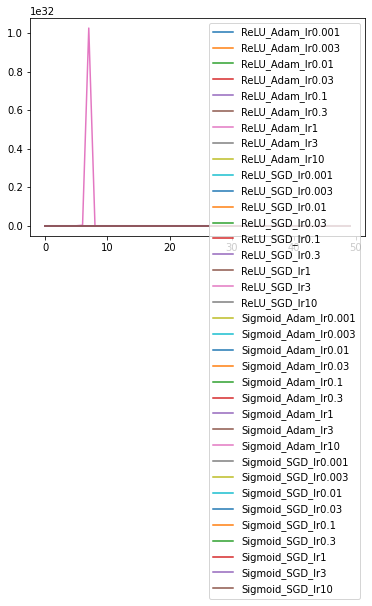

In [27]:
activations = ['ReLU', 'Sigmoid']
optimizers = ['Adam', 'SGD']
learning_rates = [1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1, 3, 10]

train_chedule = []
loss_hist_columns = []
for act in activations:
    for opt in optimizers:
        for lr in learning_rates:
            train_chedule.append({
                'activation': act,
                'optimizer': opt,
                'learning_rate': lr
            })
            loss_hist_columns.append(get_losshist_column(act, opt, lr))

epochs = 50
loss_history = pd.DataFrame(index=range(epochs), columns=loss_hist_columns, dtype=float)
log_dir = 'lenet_log'
os.makedirs(log_dir, exist_ok=True)
for params in train_chedule:
    train_model(epochs,
                params['activation'],
                params['optimizer'],
                params['learning_rate'],
                loss_history,
                log_dir)


pd.options.display.float_format = '{:.4f}'.format
print(f'Final loss: {loss_history.iloc[-1]}')
_ = loss_history.plot()
    

In [28]:
loss_history.to_pickle(os.path.join(log_dir, 'lenet_loss.pkl'))

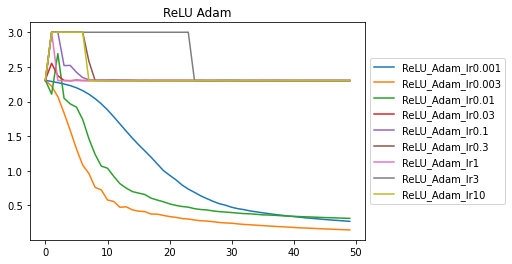

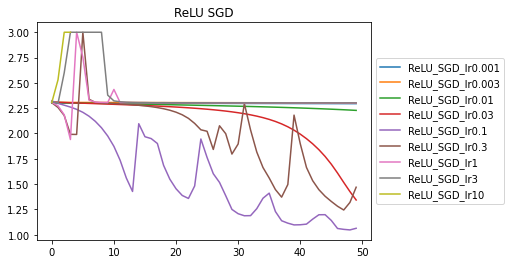

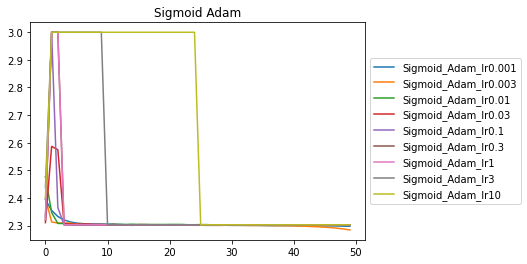

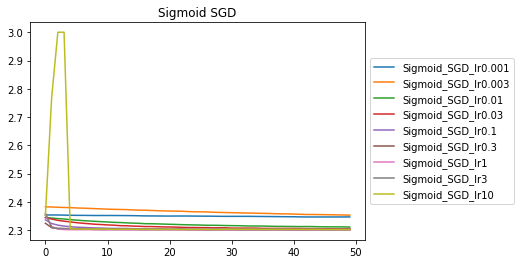

In [45]:
# Отрисуем ход обучения отдельно ReLU, отдельно Sigmoid
loss_history.head()
loss_history = pd.read_pickle(os.path.join(log_dir, 'lenet_loss.pkl'))
history_clipped = loss_history.clip(upper=3)  # умещаем всё в один масштаб
plot_step =int(len(train_chedule)/4)
relu_adam = history_clipped.iloc[:,0:plot_step]
relu_sgd = history_clipped.iloc[:,plot_step:2*plot_step]
sig_adam = history_clipped.iloc[:,2*plot_step:3*plot_step]
sig_sgd = history_clipped.iloc[:,3*plot_step:4*plot_step]

f = plt.figure()
plt.title('ReLU Adam', color='black')
relu_adam.plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

f = plt.figure()
plt.title('ReLU SGD', color='black')
relu_sgd.plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

f = plt.figure()
plt.title('Sigmoid Adam', color='black')
sig_adam.plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

f = plt.figure()
plt.title('Sigmoid SGD', color='black')
sig_sgd.plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [63]:
# Проверяем особые случаи, где был намёк на обучение с большим числом эпох
epochs = 150
variants = [{'activation': 'ReLU', 'optimizer': 'Adam', 'learning_rate': '0.00', 'lr': 0.003},
            {'activation': 'ReLU', 'optimizer': 'SGD', 'learning_rate': '0.10', 'lr': 0.1},
            {'activation': 'Sigmoid', 'optimizer': 'Adam', 'learning_rate': '0.00', 'lr': 0.003},
            {'activation': 'Sigmoid', 'optimizer': 'SGD', 'learning_rate': '10.00', 'lr': 10}]

loss_history_extra = pd.DataFrame(index=range(epochs), dtype=float)
log_dir_extra = os.path.join(log_dir, 'extra')
os.makedirs(log_dir_extra, exist_ok=True)

# Дообучение
for variant in variants:
    model_fname = os.path.join(log_dir, f"lenet{variant['activation']}_{variant['optimizer']}_{variant['learning_rate']}.pth")
    train_model(epochs,
                variant['activation'],
                variant['optimizer'],
                variant['lr'],
                loss_history_extra,
                log_dir_extra,
                model_fname)
loss_history_extra.to_pickle(os.path.join(log_dir_extra, 'lenet_loss_extra.pkl'))

Epoch 150, Sigmoid_SGD_lr10: 100%|██████████████████| 150/150 [13:45<00:00,  5.50s/it, accuracy=0.0892, loss=2.3031154]


TypeError: expected str, bytes or os.PathLike object, not DataFrame

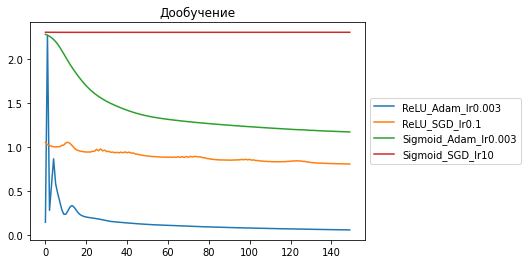

In [66]:
# Посмотрим, что дало дообучение
loss_history_load = pd.read_pickle(os.path.join(log_dir_extra, 'lenet_loss_extra.pkl'))
f = plt.figure()
plt.title('Дообучение', color='black')
loss_history_load.plot(ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [67]:
loss_history_extra

,ReLU_Adam_lr0.003,ReLU_SGD_lr0.1,Sigmoid_Adam_lr0.003,Sigmoid_SGD_lr10
0,0.1442,1.0507,2.2800,2.3034
1,2.2665,1.0262,2.2703,2.3030
2,0.2806,1.0180,2.2574,2.3030
3,0.5659,1.0065,2.2415,2.3029
4,0.8657,1.0049,2.2210,2.3030
...,...,...,...,...
145,0.0591,0.8083,1.1739,2.3031
146,0.0588,0.8078,1.1733,2.3031
147,0.0584,0.8074,1.1722,2.3032
148,0.0581,0.8070,1.1713,2.3031


In [132]:
#### Визуализация слоёв для лучшей сети
model = torch.load(os.path.join('lenet_log', 'extra', 'lenetReLU_Adam_0.0030.pth'))
model.eval()

Model(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (a1): ReLU()
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (a2): ReLU()
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (a3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (a4): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (a5): GELU()
)

In [133]:
no_of_layers=0
conv_layers=[]
model_children=list(model.children())

for child in model_children:
  if type(child)==nn.Conv2d:
    no_of_layers+=1
    conv_layers.append(child)
  elif type(child)==nn.Sequential:
    for layer in child.children():
      if type(layer)==nn.Conv2d:
        no_of_layers+=1
        conv_layers.append(layer)
print(no_of_layers)

2


In [134]:
def plot_kernels(tensor, num_cols=8):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

Layer  1


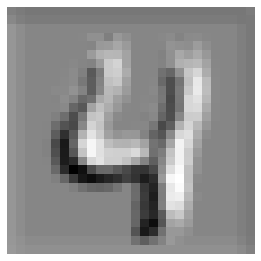

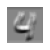

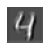

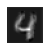

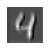

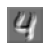

Layer  2


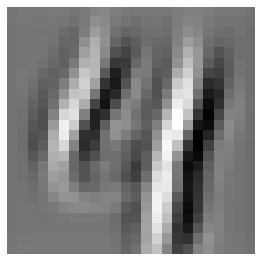

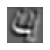

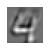

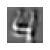

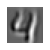

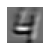

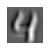

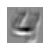

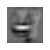

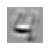

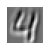

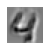

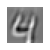

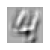

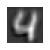

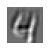

Layer  1


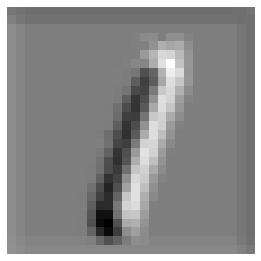

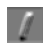

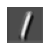

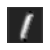

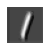

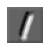

Layer  2


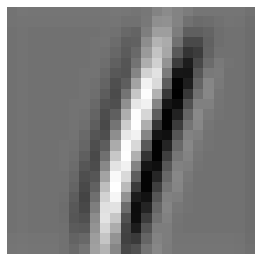

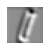

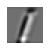

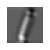

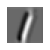

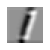

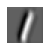

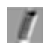

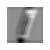

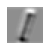

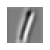

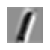

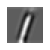

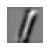

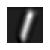

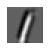

Layer  1


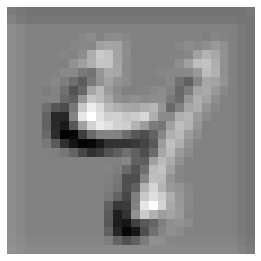

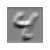

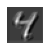

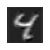

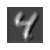

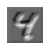

Layer  2


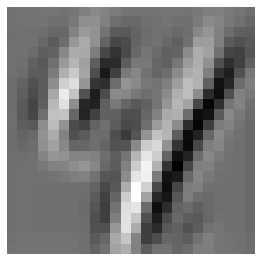

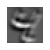

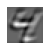

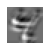

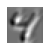

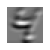

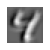

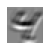

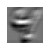

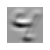

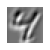

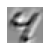

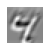

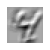

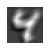

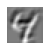

Layer  1


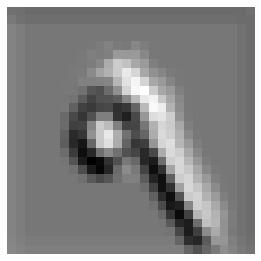

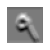

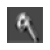

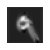

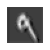

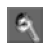

Layer  2


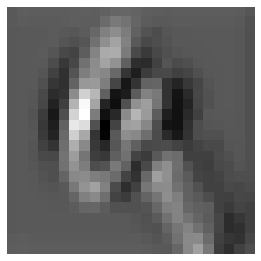

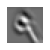

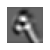

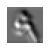

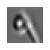

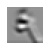

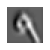

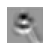

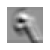

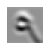

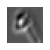

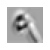

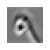

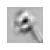

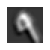

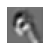

Layer  1


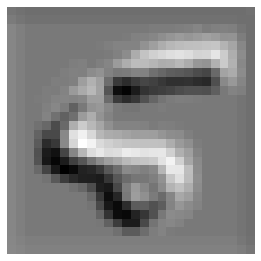

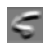

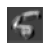

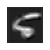

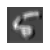

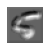

Layer  2


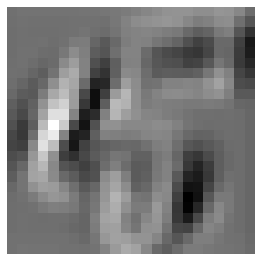

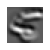

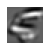

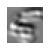

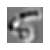

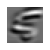

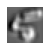

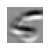

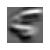

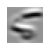

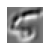

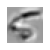

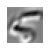

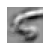

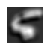

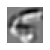

Layer  1


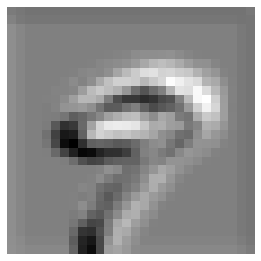

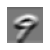

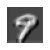

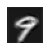

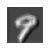

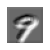

Layer  2


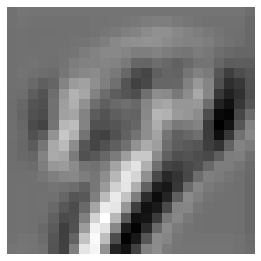

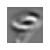

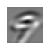

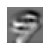

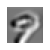

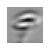

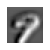

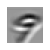

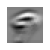

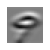

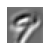

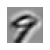

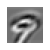

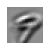

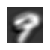

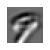

In [140]:
for i in range(4,10):
    results = [conv_layers[0](test_x[i,:,:,:].unsqueeze(0))]
    for i in range(1, len(conv_layers)):
        results.append(conv_layers[i](results[-1]))
        weights.append(conv_layers[i].weight)
    outputs = results
    for num_layer in range(len(outputs)):
        plt.figure(figsize=(50, 10))
        layer_viz = outputs[num_layer][0, :, :, :]
        layer_viz = layer_viz.data
        print("Layer ",num_layer+1)
        for i, filter in enumerate(layer_viz):
            if i == 16: 
                break
            weight = conv_layers[num_layer].weight[i].detach().numpy()
#             print(weight.shape)
#             print(weight)
            plt.subplot(2, 8, i + 1)
            plt.imshow(filter, cmap='gray')
            plt.axis("off")
            plt.show()
#         plt.show()
        plt.close()

In [90]:
print(conv_layers[0].weight[0])

tensor([[[ 0.1910, -0.0262, -0.1645, -0.4781, -0.3326],
         [ 0.0278,  0.2788, -0.0362, -0.3170, -0.2326],
         [ 0.1017,  0.0726,  0.1810,  0.1756,  0.1269],
         [ 0.1194,  0.0939,  0.2228,  0.0723, -0.1671],
         [ 0.0921,  0.1719, -0.1078,  0.1297,  0.0731]]],
       grad_fn=<SelectBackward>)


In [118]:
len(conv_layers[num_layer].weight[0]

tensor([[[[ 1.7738e-01, -6.5243e-02, -1.9422e-01,  1.8597e-02, -5.8416e-02],
          [ 1.0886e-01, -2.0459e-01, -1.9887e-01, -4.7125e-02,  8.7662e-02],
          [-1.9368e-02, -2.8483e-02,  2.2425e-02,  9.3239e-02,  8.8076e-02],
          [-6.7949e-02, -5.4392e-02,  2.2556e-02,  9.7150e-02,  5.6065e-03],
          [-1.7895e-02, -1.1158e-01,  5.6081e-02,  1.0869e-01,  1.1802e-01]],

         [[ 5.9942e-02, -1.0611e-01,  9.6024e-03, -9.2655e-02,  8.3415e-02],
          [ 2.1267e-02, -1.2369e-02,  8.0235e-02, -5.0741e-02,  4.3236e-02],
          [-2.1517e-02,  7.5617e-03, -1.0190e-01,  2.3149e-02, -1.8826e-02],
          [-1.7167e-02, -2.1651e-02, -4.3172e-02, -6.2324e-02,  8.9886e-03],
          [-5.2803e-04, -9.4909e-02, -5.8342e-03, -1.1648e-01,  3.7016e-02]],

         [[ 8.6958e-02, -1.6006e-01, -4.3538e-02,  1.1035e-01,  6.8773e-02],
          [-2.4051e-02, -1.4667e-01,  1.6919e-01,  1.6387e-01, -5.7115e-02],
          [-1.6954e-01, -6.1880e-02,  1.6785e-02,  1.1417e-01, -2.0286e-